(560, 558)


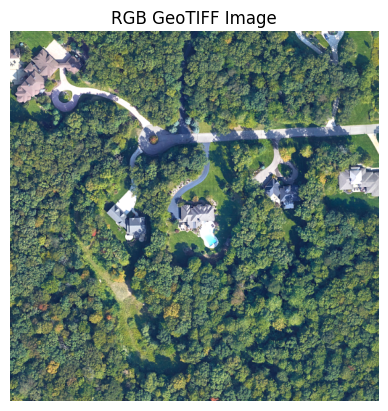

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def visualize_geotiff_rgb(filepath):
    """
    Visualize a GeoTIFF file as an RGB image, assuming the file has no extension but contains at least three bands.
    
    Args:
    filepath (str): Path to the GeoTIFF file without the extension.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")
            print(src.shape)
            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Stack bands
            rgb = np.dstack((red, green, blue))
            
    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb.astype('float32')
    max_val = np.percentile(rgb, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('RGB GeoTIFF Image')
    plt.axis('off')  # Hide axes
    plt.show()


# Example usage
visualize_geotiff_rgb(r'C:\Users\Ciel Sun\OneDrive - UW\PSC Consulting - Identifying and Estimating BTM PV Capacity on a Feeder\Custom Data Collection\Example GeoTIFFs\1099 Skyevale NE\rgbUrl 1099 Skyevale NE')

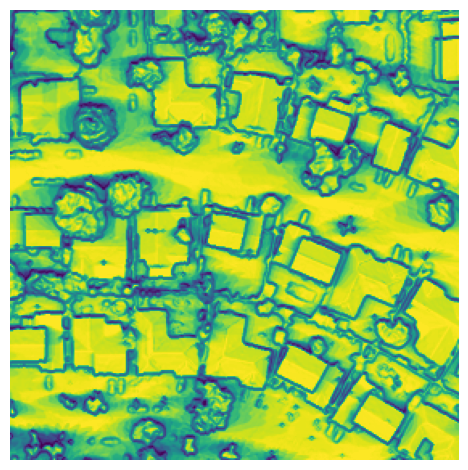

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def visualize_flux_map(filepath, month=None):
    """
    Visualize a GeoTIFF file containing monthly flux maps. Option to display a specified month's flux map 
    or the annual (sum of all channels) flux map.
    
    Args:
    filepath (str): Path to the GeoTIFF file.
    month (int, optional): The month to display (1 for January, 12 for December). 
                           If None, the annual flux map (sum of all months) will be displayed.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the month is not between 1 and 12 or if the file does not contain 12 bands.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if there are exactly 12 bands
            if src.count != 12:
                raise ValueError("GeoTIFF file does not contain exactly 12 bands (requires 12 bands for each month).")
            
            # Check for valid month input
            if month is not None and (month < 1 or month > 12):
                raise ValueError("Month must be between 1 and 12.")
            
            if month is None:
                # Read all 12 bands and compute the annual flux map
                annual_flux = np.zeros(src.read(1).shape, dtype='float32')
                for i in range(1, 13):
                    annual_flux += src.read(i)
                data_to_display = annual_flux
                title = "Annual Flux Map"
            else:
                # Read the specified month's band
                data_to_display = src.read(month)
                title = f"Flux Map for Month {month}"
            
    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the data for plotting
    data_normalized = data_to_display.astype('float32')
    max_val = np.percentile(data_to_display, 99)
    data_normalized /= max_val

    # Clip values to the range [0, 1]
    data_normalized = np.clip(data_normalized, 0, 1)

    # Plotting the data
    plt.imshow(data_normalized, cmap='viridis')
    # plt.title(title)
    # plt.colorbar(label='kWh/kW/year')
    plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

visualize_flux_map(r"C:\Users\Ciel Sun\OneDrive - UW\PSC Consulting - Identifying and Estimating BTM PV Capacity on a Feeder\Custom Data Collection\Example Dataset\4872_Canary_Dr_Pleasanton_CA_94566\monthlyFlux_4872_Canary_Dr_Pleasanton_CA_94566.tif",
                   month=6)

In [32]:
def get_monthly_flux_sum_with_mask(filepath, month, pixel_coordinates):
    """
    Calculate the summed flux for a specific month and pixel coordinates from a GeoTIFF file using a masking approach.
    
    Args:
    filepath (str): Path to the GeoTIFF file without the extension.
    month (int): Month number (1 for January, 2 for February, ..., 12 for December).
    pixel_coordinates (list of tuples): List of (x, y) tuples representing pixel coordinates.
    
    Returns:
    float: Summed flux value for the specified month and pixels.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    IndexError: If the month is out of range or the pixel coordinates are out of the image bounds.
    ValueError: If the month is not within the valid range.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if the specified month is valid
            if month < 1 or month > 12:
                raise ValueError("Month must be between 1 and 12.")
                
            # Read the specified band for the month
            band_data = src.read(month)
            print("src type: ", type(src), f" | {src.count} band(s)")
            print("band type: ", type(band_data), "| shape: ", band_data.shape)

            # Create an empty mask with the same dimensions as the band data
            mask = np.zeros_like(band_data, dtype=bool)
            
            # Set the mask to True for each pixel coordinate
            for x, y in pixel_coordinates:
                if not (0 <= x < src.width and 0 <= y < src.height):
                    raise IndexError(f"Pixel coordinates {(x, y)} are out of image bounds.")
                mask[y, x] = True

            # Apply the mask to the band data and sum the values
            flux_sum = band_data[mask].sum()

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    return flux_sum

# Example usage:
filepath = r'C:\Users\Ciel Sun\OneDrive - UW\PSC Consulting - Identifying and Estimating BTM PV Capacity on a Feeder\Custom Data Collection\Example GeoTIFFs\1099 Skyevale NE\monthlyFluxUrl 1099 Skyevale NE'
month = 5  # May
pixel_coordinates = [(10, 10), (20, 20)]
summed_flux = get_monthly_flux_sum_with_mask(filepath, month, pixel_coordinates)
print(f"Summed Flux for May at specified pixels: {summed_flux:.2f} kWh/kW/year")

src type:  <class 'rasterio.io.DatasetReader'>  | 12 band(s)
band type:  <class 'numpy.ndarray'> | shape:  (560, 558)
Summed Flux for May at specified pixels: 229.46 kWh/kW/year


In [38]:
def get_annual_flux_sum(filepath, pixel_coordinates):
    """
    Calculate the summed annual flux for pixel coordinates from a GeoTIFF file using a masking approach.
    
    Args:
    filepath (str): Path to the GeoTIFF file without the extension.
    pixel_coordinates (list of tuples): List of (x, y) tuples representing pixel coordinates.
    
    Returns:
    float: Summed annual flux value for the specified pixels, excluding invalid data points.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    IndexError: If the pixel coordinates are out of the image bounds.
    """
    try:
        with rasterio.open(filepath) as src:
            # Read the annual flux data (assuming it's stored in the first band)
            band_data = src.read(1)
            
            print("src type: ", type(src), f" | {src.count} band(s)")
            print("band type: ", type(band_data), "| shape: ", band_data.shape)
            # Create an empty mask with the same dimensions as the band data
            mask = np.zeros_like(band_data, dtype=bool)
            
            # Set the mask to True for each pixel coordinate
            for x, y in pixel_coordinates:
                if not (0 <= x < src.width and 0 <= y < src.height):
                    raise IndexError(f"Pixel coordinates {(x, y)} are out of image bounds.")
                mask[y, x] = True

            # Apply the mask to the band data
            selected_flux = band_data[mask]

            # Remove invalid data points (values of -9999)
            valid_flux = selected_flux[selected_flux != -9999]

            # Sum the valid flux values
            flux_sum = valid_flux.sum()

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    return flux_sum

# Example usage:
filepath = r'C:\Users\Ciel Sun\OneDrive - UW\PSC Consulting - Identifying and Estimating BTM PV Capacity on a Feeder\Custom Data Collection\Example GeoTIFFs\1099 Skyevale NE\annualFluxUrl 1099 Skyevale NE'
pixel_coordinates = [(10, 10), (20, 20)]
annual_flux_sum = get_annual_flux_sum(filepath, pixel_coordinates)
print(f"Summed Annual Flux at specified pixels: {annual_flux_sum:.2f} kWh/kW/year")


src type:  <class 'rasterio.io.DatasetReader'>  | 1 band(s)
band type:  <class 'numpy.ndarray'> | shape:  (560, 558)
Summed Annual Flux at specified pixels: 1912.53 kWh/kW/year


In [37]:
def get_annual_flux_sum_from_monthly(filepath, pixel_coordinates):
    """
    Calculate the annual summed flux from monthly data for specified pixel coordinates in a GeoTIFF file.
    
    Args:
    filepath (str): Path to the GeoTIFF file without the extension.
    pixel_coordinates (list of tuples): List of (x, y) tuples representing pixel coordinates.
    
    Returns:
    float: Annual summed flux value for the specified pixels, excluding invalid data points.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    IndexError: If the pixel coordinates are out of the image bounds.
    """
    try:
        with rasterio.open(filepath) as src:
            # Ensure there are exactly 12 bands (one for each month)
            if src.count != 12:
                raise ValueError("The GeoTIFF file does not contain 12 bands for monthly data.")

            # Initialize an array to accumulate the flux sums
            annual_flux = np.zeros(len(pixel_coordinates))

            # Process each band (month)
            for month in range(1, 13):  # Bands are 1-indexed in rasterio
                band_data = src.read(month)

                # Sum the flux for each coordinate
                for idx, (x, y) in enumerate(pixel_coordinates):
                    if not (0 <= x < src.width and 0 <= y < src.height):
                        raise IndexError(f"Pixel coordinates {(x, y)} are out of image bounds.")
                    flux_value = band_data[y, x]
                    # Check for valid flux value (not -9999)
                    if flux_value != -9999:
                        annual_flux[idx] += flux_value

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    return annual_flux.sum()  # Return the total annual flux for all provided coordinates

# Example usage:
filepath = r'C:\Users\Ciel Sun\OneDrive - UW\PSC Consulting - Identifying and Estimating BTM PV Capacity on a Feeder\Custom Data Collection\Example GeoTIFFs\1099 Skyevale NE\monthlyFluxUrl 1099 Skyevale NE'
pixel_coordinates = [(10, 10), (20, 20)]
total_annual_flux = get_annual_flux_sum_from_monthly(filepath, pixel_coordinates)
print(f"Summed Annual Flux from monthly flux at specified pixels: {annual_flux_sum:.2f} kWh/kW/year")


Summed Annual Flux from monthly flux at specified pixels: 1912.53 kWh/kW/year


In [4]:
monthlyFlux_path = r"C:\Users\Ciel Sun\OneDrive - UW\PSC Consulting - Identifying and Estimating BTM PV Capacity on a Feeder\Custom Data Collection\Example GeoTIFFs\TestAddresses 70 meters\6200_Tahoe_Dr_SE,_Grand_Rapids,_MI_49546\monthlyFlux_6200_Tahoe_Dr_SE,_Grand_Rapids,_MI_49546.tif"
with rasterio.open(monthlyFlux_path) as src:
            if src.count != 12:
                raise ValueError("The GeoTIFF file does not contain 12 bands, as required for monthly data.")